In [2]:
# 필요한 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
# 데이터 불러오기
df = pd.read_csv("C:/msys64/home/for/10th/standard/LinearBNB/2025_Airbnb_NYC_listings.csv")

In [4]:
# 전처리 
# 가격 '$', ',' 때고 숫자형으로 바꾸기
df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
df['price'] = df['price'].astype(float)
df['price'] = df['price'].astype(int)

# 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating' 중 하나라도 결측치가 있는 '행(row)'을 제거
# 수가 적기 때문 / 리뷰가 있는 데이터를 예약이 된 숙소라고 판단.
df.dropna(subset=['bathrooms', 'bedrooms', 'beds', 'review_scores_rating'], inplace=True)

# 너무 오래된 리뷰 데이터는 제거
old_date = pd.to_datetime('2023-03-02')
df['last_review'] = pd.to_datetime(df['last_review'])
df = df[df['last_review'] >= old_date].copy()


df.reset_index(drop=True, inplace=True)


C:\Users\for\AppData\Local\Temp\ipykernel_12716\3174411339.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$', '').str.replace(',', '')


In [5]:
features =['neighbourhood_cleansed',       # 정제된 동네 이름
            'neighbourhood_group_cleansed', # 자치구 단위 지역 그룹 (맨해튼, 브루클린 등)
            'property_type',                # 숙소 유형 (아파트, 집 등)
            'room_type',                    # 방 유형 (전체, 개인실 등)
            'accommodates',                 # 수용 인원
            'bathrooms',                    # 욕실 개수             
            'bedrooms',                     # 침실 개수
            'beds',                         # 침대 개수
            'amenities',                    # 편의 시설
            'minimum_nights',               # 최소 숙박 일수
            'maximum_nights',
            'price']              # 최대 숙박 일수

In [6]:
df[features].isna().sum()

neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
amenities                       0
minimum_nights                  0
maximum_nights                  0
price                           0
dtype: int64

In [7]:
df = df[features]
df.T

,0,1,2,3,4,5,6,7,8,9,...,13521,13522,13523,13524,13525,13526,13527,13528,13529,13530
neighbourhood_cleansed,East Harlem,Boerum Hill,Harlem,Williamsburg,Williamsburg,East Harlem,Fort Greene,Williamsburg,Bedford-Stuyvesant,Bedford-Stuyvesant,...,Upper West Side,Williamsburg,Bushwick,Midtown,Midtown,East Village,Midtown,Financial District,Hell's Kitchen,Hell's Kitchen
neighbourhood_group_cleansed,Manhattan,Brooklyn,Manhattan,Brooklyn,Brooklyn,Manhattan,Brooklyn,Brooklyn,Brooklyn,Brooklyn,...,Manhattan,Brooklyn,Brooklyn,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan
property_type,Private room in condo,Private room in home,Entire home,Private room in rental unit,Entire rental unit,Private room in rental unit,Private room in guest suite,Entire place,Entire loft,Entire loft,...,Private room in rental unit,Entire condo,Private room in rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit
room_type,Private room,Private room,Entire home/apt,Private room,Entire home/apt,Private room,Private room,Entire home/apt,Entire home/apt,Entire home/apt,...,Private room,Entire home/apt,Private room,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
accommodates,2,2,2,2,3,1,2,2,5,5,...,1,4,2,4,4,4,6,9,5,5
bathrooms,1.0,2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,1.5,1.0,1.0,2.0,2.0,3.0,1.0,2.0
bedrooms,1.0,5.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,2.0,...,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0
beds,1.0,5.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,4.0,...,1.0,2.0,1.0,2.0,2.0,2.0,3.0,5.0,3.0,2.0
amenities,"[""Oven"", ""Blender"", ""Luggage dropoff allowed"",...","[""Portable fans"", ""Oven"", ""Baking sheet"", ""Fir...","[""Fire extinguisher"", ""Clothing storage: close...","[""Oven"", ""Rice maker"", ""Laundromat nearby"", ""L...","[""Oven"", ""Fire extinguisher"", ""Extra pillows a...","[""Fire extinguisher"", ""Extra pillows and blank...","[""Garden view"", ""Fire extinguisher"", ""First ai...","[""Baking sheet"", ""Fire extinguisher"", ""First a...","[""Baking sheet"", ""Oven"", ""Rice maker"", ""Laundr...","[""Baking sheet"", ""Oven"", ""Blender"", ""Luggage d...",...,"[""Fire extinguisher"", ""First aid kit"", ""Dedica...","[""Fire extinguisher"", ""Keypad"", ""Hair dryer"", ...","[""Laundromat nearby"", ""Luggage dropoff allowed...","[""Stainless steel electric stove"", ""Gym"", ""Lau...","[""Laundromat nearby"", ""Fire extinguisher"", ""Pa...","[""Oven"", ""First aid kit"", ""Free washer \u2013 ...","[""Oven"", ""First aid kit"", ""Dining table"", ""Coo...","[""Oven"", ""First aid kit"", ""Dining table"", ""Ext...","[""Stainless steel electric stove"", ""Fire extin...","[""Baking sheet"", ""Oven"", ""Dedicated workspace""..."
minimum_nights,30,3,2,4,30,30,2,30,30,30,...,30,3,1,1,2,1,2,1,2,4


In [8]:
df.shape

(13531, 12)

# 파생 컬럼 생성

In [9]:
# 지역적 특성을 통해 지역을 그룹화 하기

geo_mapping = {
    # 1. 중심 관광/비즈니스 (High-Density, Global Hub)
    'Midtown': 'Global_Hub', 'Hell\'s Kitchen': 'Global_Hub', 'Chelsea': 'Global_Hub', 
    'Financial District': 'Global_Hub', 'Theater District': 'Global_Hub', 'Murray Hill': 'Global_Hub',
    'Kips Bay': 'Global_Hub', 'West Village': 'Global_Hub', 'SoHo': 'Global_Hub', 'Chinatown': 'Global_Hub',

    # 2. 힙스터/예술/트렌디 (Trendy & Cultural)
    'Williamsburg': 'Trendy_Hip', 'Bushwick': 'Trendy_Hip', 'Greenpoint': 'Trendy_Hip', 
    'Astoria': 'Trendy_Hip', 'Long Island City': 'Trendy_Hip', 'Ridgewood': 'Trendy_Hip',
    'East Village': 'Trendy_Hip', 'Lower East Side': 'Trendy_Hip',

    # 3. 안정적인 주거/부촌 (Established Residential)
    'Upper East Side': 'Established_Res', 'Upper West Side': 'Established_Res', 
    'Park Slope': 'Established_Res', 'Brooklyn Heights': 'Established_Res', 
    'Clinton Hill': 'Established_Res', 'Fort Greene': 'Established_Res',

    # 4. 급부상/가성비 주거지역 (Up-and-Coming / Commuter)
    'Bedford-Stuyvesant': 'Up_and_Coming', 'Harlem': 'Up_and_Coming', 
    'Crown Heights': 'Up_and_Coming', 'East Harlem': 'Up_and_Coming', 
    'Flatbush': 'Up_and_Coming', 'Washington Heights': 'Up_and_Coming',
    'Prospect-Lefferts Gardens': 'Up_and_Coming', 'Sunnyside': 'Up_and_Coming',

    # 5. 외곽/교외 지역 (Outer Suburban)
    'Flushing': 'Outer_Suburban', 'Jamaica': 'Outer_Suburban', 'East New York': 'Outer_Suburban',
    'Canarsie': 'Outer_Suburban', 'St. Albans': 'Outer_Suburban', 'Jackson Heights': 'Outer_Suburban'
}

# 데이터프레임 적용
# 딕셔너리에 없는 나머지 동네들은 'Others'로 처리
df['geo_characteristic'] = df['neighbourhood_cleansed'].map(geo_mapping).fillna('Others')

df['geo_characteristic'].unique()

array(['Up_and_Coming', 'Others', 'Trendy_Hip', 'Established_Res',
       'Global_Hub', 'Outer_Suburban'], dtype=object)

In [10]:
# 동네별 평균 가격을 기준으로 동네들 그룹화 하기

# 1. 동네별 평균 가격 계산 (Series 형태)
neighborhood_avg = df.groupby('neighbourhood_cleansed')['price'].mean()

# 2. 평균 가격을 기준으로 4개 등급(Luxury, High, Mid, Budget)으로 나누기
# qcut은 데이터 개수가 균등하게 배분되도록 등급을 나눕니다.
price_labels = ['Budget', 'Mid-Range', 'High-End', 'Luxury']
df['price_group'] = pd.qcut(df['neighbourhood_cleansed'].map(neighborhood_avg), 
                            q=4, 
                            labels=price_labels)


In [11]:
# 화장실 상한선 적용하기

# (1.5개 같은 화장실을 2.0으로 만듭니다)
df['bathrooms'] = np.ceil(df['bathrooms'])

# 상한선(Capping) 적용
df['bathrooms_clipped'] = df['bathrooms'].clip(upper=5.0)

# 결과 확인
print(df['bathrooms_clipped'].value_counts().sort_index())

0.0       91
1.0    11112
2.0     1948
3.0      269
4.0       80
5.0       31
Name: bathrooms_clipped, dtype: int64


In [12]:
# 침실 상한선 적용하기
df['bedrooms_clipped'] = df['bedrooms'].clip(upper=6.0)
df['bedrooms_clipped'].value_counts()

1.0    8419
2.0    2400
0.0    1479
3.0     908
4.0     221
5.0      70
6.0      34
Name: bedrooms_clipped, dtype: int64

In [13]:
# 침대 상한선 적용하기
df['beds_clipped'] = df['beds'].clip(upper=9.0)
df['beds_clipped'].value_counts()

1.0    7478
2.0    3381
3.0    1298
4.0     659
0.0     275
5.0     230
6.0     112
7.0      42
8.0      35
9.0      21
Name: beds_clipped, dtype: int64

In [14]:
# 편의시설 파생 컬럼

import ast
import re


# 편의시설 파싱 함수
def clean_amenities(x):
    if pd.isna(x): return []
    x = x.replace('{', '[').replace('}', ']')
    try:
        return [i.strip().lower() for i in ast.literal_eval(x)]
    except:
        return [i.strip().lower() for i in re.sub(r'[\[\]\"\'\{\}]', '', x).split(',') if i.strip()]

df['amenities_list'] = df['amenities'].apply(clean_amenities)


# 카테고리 정의 (키워드 기반)
categories = {
    'luxury_score': ['elevator', 'gym', 'pool'],
    'service_score': ['washer', 'coffee maker', 'self check-in', 'pet'],
    'longterm_score': ['shampoo', 'dryer', 'iron'],
    'essential_score' : ['air conditioning', 'essentials']
}

# 각 카테고리별 점수 계산 (보유한 항목의 개수)
for cat_name, keywords in categories.items():
    df[cat_name] = df['amenities_list'].apply(lambda x: sum(1 for item in x if any(k in item for k in keywords)))

    # 점수들과 log_price 간의 상관관계 계산
score_cols = list(categories.keys()) + ['amenity_count']
df['amenity_count'] = df['amenities_list'].apply(len)

In [15]:
# 'amenities_list' 컬럼 제거
df.drop(columns=['amenities_list'], inplace=True)

In [16]:
df.columns

Index(['neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'minimum_nights', 'maximum_nights', 'price',
       'geo_characteristic', 'price_group', 'bathrooms_clipped',
       'bedrooms_clipped', 'beds_clipped', 'luxury_score', 'service_score',
       'longterm_score', 'essential_score', 'amenity_count'],
      dtype='object')

# 분석에 사용할 컬럼 소개

### **원래 있던 컬럼**

---------------------------------------------------------------

**지역 관련 컬럼**
- **neighbourhood_cleansed** : 정제된 동네 이름
- **neighbourhood_group_cleansed** : 정제된 구/군 단위 지역 그룹

---------------------------------------------------------------

**숙소 시설 및 상세 사양**
- **property_type**: 숙소 유형
- **room_type**: 방 유형
- **accommodates**: 수용 인원
- **Luxury_Score**: 욕실 개수
- **bedrooms**: 침실 개수
- **beds**: 침대 개수
- **amenities**: 편의시설 목록

---------------------------------------------------------------

**예약 규칙 및 가용성**
- **minimum_nights**: 최소 숙박 일수
- **maximum_nights**: 최대 숙박 일수
---------------------------------------------------------------

### **새롭게 만든 컬럼**

---------------------------------------------------------------

**지역 관련 컬럼**
- **geo_characteristic** : 지역적 특성에 따라 지역을 분류
- **price_group** : 평균 가격에 따라 지역을 분류

---------------------------------------------------------------

**숙소 시설 및 상세 사양**
- **bathrooms_clipped**: 화장실에 제한 0.5개는 올
- **bedrooms_clipped**: 침실에 제한
- **beds_clipped**: 침대에 제한
- 
---------------------------------------------------------------

**예약 규칙 및 가용성**
- **luxury_score**: 편의 시설 중 'elevator', 'gym', 'pool' 이 포함된 개수
- **service_score**: 편의 시설 중 'washer', 'coffee maker', 'self check-in', 'pet' 이 포함된 개수
- **longterm_score**: 편의 시설 중 'shampoo', 'dryer', 'iron' 이 포함된 개수
- **amenity_count**: 편의시설 개수
---------------------------------------------------------------

In [17]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,13521,13522,13523,13524,13525,13526,13527,13528,13529,13530
neighbourhood_cleansed,East Harlem,Boerum Hill,Harlem,Williamsburg,Williamsburg,East Harlem,Fort Greene,Williamsburg,Bedford-Stuyvesant,Bedford-Stuyvesant,...,Upper West Side,Williamsburg,Bushwick,Midtown,Midtown,East Village,Midtown,Financial District,Hell's Kitchen,Hell's Kitchen
neighbourhood_group_cleansed,Manhattan,Brooklyn,Manhattan,Brooklyn,Brooklyn,Manhattan,Brooklyn,Brooklyn,Brooklyn,Brooklyn,...,Manhattan,Brooklyn,Brooklyn,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan
property_type,Private room in condo,Private room in home,Entire home,Private room in rental unit,Entire rental unit,Private room in rental unit,Private room in guest suite,Entire place,Entire loft,Entire loft,...,Private room in rental unit,Entire condo,Private room in rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit
room_type,Private room,Private room,Entire home/apt,Private room,Entire home/apt,Private room,Private room,Entire home/apt,Entire home/apt,Entire home/apt,...,Private room,Entire home/apt,Private room,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
accommodates,2,2,2,2,3,1,2,2,5,5,...,1,4,2,4,4,4,6,9,5,5
bathrooms,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,2.0
bedrooms,1.0,5.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,2.0,...,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0
beds,1.0,5.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,4.0,...,1.0,2.0,1.0,2.0,2.0,2.0,3.0,5.0,3.0,2.0
amenities,"[""Oven"", ""Blender"", ""Luggage dropoff allowed"",...","[""Portable fans"", ""Oven"", ""Baking sheet"", ""Fir...","[""Fire extinguisher"", ""Clothing storage: close...","[""Oven"", ""Rice maker"", ""Laundromat nearby"", ""L...","[""Oven"", ""Fire extinguisher"", ""Extra pillows a...","[""Fire extinguisher"", ""Extra pillows and blank...","[""Garden view"", ""Fire extinguisher"", ""First ai...","[""Baking sheet"", ""Fire extinguisher"", ""First a...","[""Baking sheet"", ""Oven"", ""Rice maker"", ""Laundr...","[""Baking sheet"", ""Oven"", ""Blender"", ""Luggage d...",...,"[""Fire extinguisher"", ""First aid kit"", ""Dedica...","[""Fire extinguisher"", ""Keypad"", ""Hair dryer"", ...","[""Laundromat nearby"", ""Luggage dropoff allowed...","[""Stainless steel electric stove"", ""Gym"", ""Lau...","[""Laundromat nearby"", ""Fire extinguisher"", ""Pa...","[""Oven"", ""First aid kit"", ""Free washer \u2013 ...","[""Oven"", ""First aid kit"", ""Dining table"", ""Coo...","[""Oven"", ""First aid kit"", ""Dining table"", ""Ext...","[""Stainless steel electric stove"", ""Fire extin...","[""Baking sheet"", ""Oven"", ""Dedicated workspace""..."
minimum_nights,30,3,2,4,30,30,2,30,30,30,...,30,3,1,1,2,1,2,1,2,4


In [18]:
# neighbourhood_group_cleansed 정제된 지역 이름
# room_type 방 유형
# accommodates 수용 인원
# minimum_nights 최소 숙박 일수

from catboost import CatBoostClassifier

df['price_log'] = np.log(df['price'])
#df['price_log']

x_cat = df.drop('price_log', axis = 1)
y_cat = df['price_log'].astype('float')
y_cat

0        4.406719
1        6.639876
2        4.934474
3        4.867534
4        4.564348
           ...   
13526    5.805135
13527    6.146329
13528    6.142037
13529    5.840642
13530    6.848005
Name: price_log, Length: 13531, dtype: float64

In [19]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,13521,13522,13523,13524,13525,13526,13527,13528,13529,13530
neighbourhood_cleansed,East Harlem,Boerum Hill,Harlem,Williamsburg,Williamsburg,East Harlem,Fort Greene,Williamsburg,Bedford-Stuyvesant,Bedford-Stuyvesant,...,Upper West Side,Williamsburg,Bushwick,Midtown,Midtown,East Village,Midtown,Financial District,Hell's Kitchen,Hell's Kitchen
neighbourhood_group_cleansed,Manhattan,Brooklyn,Manhattan,Brooklyn,Brooklyn,Manhattan,Brooklyn,Brooklyn,Brooklyn,Brooklyn,...,Manhattan,Brooklyn,Brooklyn,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan
property_type,Private room in condo,Private room in home,Entire home,Private room in rental unit,Entire rental unit,Private room in rental unit,Private room in guest suite,Entire place,Entire loft,Entire loft,...,Private room in rental unit,Entire condo,Private room in rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit,Entire rental unit
room_type,Private room,Private room,Entire home/apt,Private room,Entire home/apt,Private room,Private room,Entire home/apt,Entire home/apt,Entire home/apt,...,Private room,Entire home/apt,Private room,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
accommodates,2,2,2,2,3,1,2,2,5,5,...,1,4,2,4,4,4,6,9,5,5
bathrooms,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,2.0
bedrooms,1.0,5.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,2.0,...,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0
beds,1.0,5.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,4.0,...,1.0,2.0,1.0,2.0,2.0,2.0,3.0,5.0,3.0,2.0
amenities,"[""Oven"", ""Blender"", ""Luggage dropoff allowed"",...","[""Portable fans"", ""Oven"", ""Baking sheet"", ""Fir...","[""Fire extinguisher"", ""Clothing storage: close...","[""Oven"", ""Rice maker"", ""Laundromat nearby"", ""L...","[""Oven"", ""Fire extinguisher"", ""Extra pillows a...","[""Fire extinguisher"", ""Extra pillows and blank...","[""Garden view"", ""Fire extinguisher"", ""First ai...","[""Baking sheet"", ""Fire extinguisher"", ""First a...","[""Baking sheet"", ""Oven"", ""Rice maker"", ""Laundr...","[""Baking sheet"", ""Oven"", ""Blender"", ""Luggage d...",...,"[""Fire extinguisher"", ""First aid kit"", ""Dedica...","[""Fire extinguisher"", ""Keypad"", ""Hair dryer"", ...","[""Laundromat nearby"", ""Luggage dropoff allowed...","[""Stainless steel electric stove"", ""Gym"", ""Lau...","[""Laundromat nearby"", ""Fire extinguisher"", ""Pa...","[""Oven"", ""First aid kit"", ""Free washer \u2013 ...","[""Oven"", ""First aid kit"", ""Dining table"", ""Coo...","[""Oven"", ""First aid kit"", ""Dining table"", ""Ext...","[""Stainless steel electric stove"", ""Fire extin...","[""Baking sheet"", ""Oven"", ""Dedicated workspace""..."
minimum_nights,30,3,2,4,30,30,2,30,30,30,...,30,3,1,1,2,1,2,1,2,4


In [20]:
df.corr(method = 'pearson')

C:\Users\for\AppData\Local\Temp\ipykernel_12716\3294333281.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method = 'pearson')


,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,price,bathrooms_clipped,bedrooms_clipped,beds_clipped,luxury_score,service_score,longterm_score,essential_score,amenity_count,price_log
accommodates,1.000000,0.378742,0.653427,0.754867,-0.067232,0.055604,0.489610,0.384079,0.650935,0.772375,0.013683,0.262020,0.182800,0.091885,0.188251,0.555157
bathrooms,0.378742,1.000000,0.482252,0.405470,0.017843,0.002364,0.386476,0.978926,0.461331,0.360082,0.012581,0.150405,0.093264,0.054139,0.119435,0.246384
bedrooms,0.653427,0.482252,1.000000,0.684812,-0.004915,0.011453,0.413753,0.477134,0.991533,0.674724,-0.090355,0.182281,0.102895,0.045638,0.186632,0.389016
beds,0.754867,0.405470,0.684812,1.000000,-0.048469,0.035523,0.416895,0.370220,0.657218,0.968678,-0.044727,0.216612,0.175668,0.076873,0.213855,0.443125
minimum_nights,-0.067232,0.017843,-0.004915,-0.048469,1.000000,0.138394,-0.110146,0.018320,-0.003922,-0.050832,-0.053021,0.009162,-0.090575,-0.045921,-0.037752,-0.164413
maximum_nights,0.055604,0.002364,0.011453,0.035523,0.138394,1.000000,0.017395,0.003731,0.011065,0.038569,0.080265,0.064471,0.045437,0.042856,-0.014605,0.012927
price,0.489610,0.386476,0.413753,0.416895,-0.110146,0.017395,1.000000,0.373022,0.400178,0.403681,0.197301,0.256044,0.195609,0.133581,0.151541,0.803362
bathrooms_clipped,0.384079,0.978926,0.477134,0.370220,0.018320,0.003731,0.373022,1.000000,0.470676,0.364290,0.010079,0.156565,0.096240,0.054428,0.124666,0.247083
bedrooms_clipped,0.650935,0.461331,0.991533,0.657218,-0.003922,0.011065,0.400178,0.470676,1.000000,0.673682,-0.092003,0.183194,0.102392,0.044622,0.189284,0.388583
beds_clipped,0.772375,0.360082,0.674724,0.968678,-0.050832,0.038569,0.403681,0.364290,0.673682,1.000000,-0.045831,0.225442,0.182796,0.078293,0.223910,0.454013


In [21]:
df.corr('spearman')

C:\Users\for\AppData\Local\Temp\ipykernel_12716\1436705525.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr('spearman')


,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,price,bathrooms_clipped,bedrooms_clipped,beds_clipped,luxury_score,service_score,longterm_score,essential_score,amenity_count,price_log
accommodates,1.000000,0.219398,0.526947,0.701181,-0.074964,0.085355,0.578142,0.219400,0.526945,0.701181,0.051792,0.293751,0.212039,0.095547,0.190318,0.578142
bathrooms,0.219398,1.000000,0.365245,0.238091,0.024858,0.020618,0.157586,1.000000,0.365245,0.238090,0.000480,0.147011,0.110073,0.038021,0.113069,0.157586
bedrooms,0.526947,0.365245,1.000000,0.592664,0.031531,0.020679,0.346911,0.365246,1.000000,0.592664,-0.108698,0.176631,0.110473,0.035919,0.195250,0.346911
beds,0.701181,0.238091,0.592664,1.000000,-0.057548,0.037740,0.451751,0.238093,0.592664,1.000000,-0.020624,0.234339,0.202352,0.078102,0.222910,0.451751
minimum_nights,-0.074964,0.024858,0.031531,-0.057548,1.000000,0.230039,-0.200277,0.024857,0.031531,-0.057548,-0.085402,0.019184,-0.090640,-0.056785,-0.023296,-0.200277
maximum_nights,0.085355,0.020618,0.020679,0.037740,0.230039,1.000000,0.008999,0.020618,0.020680,0.037740,0.090662,0.056123,0.005911,0.034334,-0.054420,0.008999
price,0.578142,0.157586,0.346911,0.451751,-0.200277,0.008999,1.000000,0.157587,0.346910,0.451750,0.214190,0.366754,0.308097,0.181143,0.209199,1.000000
bathrooms_clipped,0.219400,1.000000,0.365246,0.238093,0.024857,0.020618,0.157587,1.000000,0.365246,0.238092,0.000478,0.147013,0.110074,0.038021,0.113071,0.157587
bedrooms_clipped,0.526945,0.365245,1.000000,0.592664,0.031531,0.020680,0.346910,0.365246,1.000000,0.592664,-0.108699,0.176629,0.110471,0.035917,0.195249,0.346910
beds_clipped,0.701181,0.238090,0.592664,1.000000,-0.057548,0.037740,0.451750,0.238092,0.592664,1.000000,-0.020624,0.234338,0.202351,0.078102,0.222910,0.451750


In [22]:

#pearson
df.corr(method= 'pearson')['price_log'].abs().quantile(0.75)
# 0.44584726533323255
df.corr(method= 'pearson')['price_log'].abs() > df.corr(method= 'pearson')['price_log'].abs().quantile(0.75)
# acc, price, bedsclip, pricelog


# spearman
df.corr(method= 'spearman')['price_log'].abs().quantile(0.75)
# 0.45175057284885056
df.corr(method= 'spearman')['price_log'].abs() > df.corr(method= 'pearson')['price_log'].abs().quantile(0.75)
# acc, beds, price, bedsclip, pricelog



C:\Users\for\AppData\Local\Temp\ipykernel_12716\2328494403.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method= 'pearson')['price_log'].abs().quantile(0.75)
C:\Users\for\AppData\Local\Temp\ipykernel_12716\2328494403.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method= 'pearson')['price_log'].abs() > df.corr(method= 'pearson')['price_log'].abs().quantile(0.75)
C:\Users\for\AppData\Local\Temp\ipykernel_12716\2328494403.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to si

accommodates          True
bathrooms            False
bedrooms             False
beds                  True
minimum_nights       False
maximum_nights       False
price                 True
bathrooms_clipped    False
bedrooms_clipped     False
beds_clipped          True
luxury_score         False
service_score        False
longterm_score       False
essential_score      False
amenity_count        False
price_log             True
Name: price_log, dtype: bool

In [23]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import root_mean_squared_error


# 1. neighbourhood_group_cleansed, room_type, accommodates, minimum_nights


# x_cat = df.drop('price_log', axis = 1)
# y_cat = df['price_log'].astype('float')


# cfeatures = ['neighbourhood_group_cleansed', 'room_type', 'accommodates', 'minimum_nights']
# X = df[features].copy()
# y = df['price_log'].astype(float)

# # X, y 같이 결측 제거 (샘플수 맞추기)
# data = pd.concat([X, y.rename("y")], axis=1).dropna()
# X = data[features]
# y = data["y"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# cat_cols = ['neighbourhood_group_cleansed', 'room_type']  # ✅ 컬럼명으로 지정(실수 방지)

# model = CatBoostClassifier(
#     cat_features=cat_cols,
#     random_state=42,
#     verbose=200
# )

# model.fit(X_train, y_train)
# pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, pred)
# rmse = mean_squared_error(y_test, pred, squared=False)
# print("MAE:", mae)
# print("RMSE:", rmse)


# 1) 피처/타깃 정의
features = ['neighbourhood_group_cleansed', 'room_type', 'accommodates', 'minimum_nights']
cat_features = ['neighbourhood_group_cleansed', 'room_type']  # ✅ 범주형

X = df[features].copy()
y = df['price_log'].astype(float) #log
# y = df['price'].astype(float) #original

# 2) 결측 제거 (X,y 같이)
data = pd.concat([X, y.rename("y")], axis=1).dropna()
X = data[features]
y = data["y"]

# (선택) 범주형 dtype 안정화
for c in cat_features:
    X[c] = X[c].astype('category')

# 3) split (회귀라 stratify 없음)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) 모델
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

# ✅ cat_features는 fit에서 주는 게 가장 안전
cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

# 5) 평가
y_pred = cat_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

y_pred = cat_model.predict(X_test)
print("-" * 30)
print(f'Tuned CatBoost R2 : {r2_score(y_test, y_pred):.4f}')
print(f'Tuned CatBoost RMSE : {root_mean_squared_error(y_test, y_pred):.4f}')

C:\Users\for\AppData\Local\Temp\ipykernel_12716\673673672.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')
C:\Users\for\AppData\Local\Temp\ipykernel_12716\673673672.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')


0:	learn: 0.6556607	test: 0.6425225	best: 0.6425225 (0)	total: 166ms	remaining: 2m 45s
100:	learn: 0.4547937	test: 0.4580511	best: 0.4580511 (100)	total: 1.78s	remaining: 15.9s
200:	learn: 0.4512859	test: 0.4569121	best: 0.4569121 (200)	total: 3.38s	remaining: 13.4s
300:	learn: 0.4495683	test: 0.4564713	best: 0.4564472 (294)	total: 5.02s	remaining: 11.7s
400:	learn: 0.4482244	test: 0.4562372	best: 0.4562146 (389)	total: 6.66s	remaining: 9.95s
500:	learn: 0.4469523	test: 0.4559983	best: 0.4559787 (485)	total: 8.24s	remaining: 8.21s
600:	learn: 0.4457959	test: 0.4557669	best: 0.4557580 (575)	total: 9.91s	remaining: 6.58s
700:	learn: 0.4446036	test: 0.4556269	best: 0.4556141 (688)	total: 11.9s	remaining: 5.07s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4556140809
bestIteration = 688

Shrink model to first 689 iterations.
------------------------------
Tuned CatBoost R2 : 0.5194
Tuned CatBoost RMSE : 0.4556


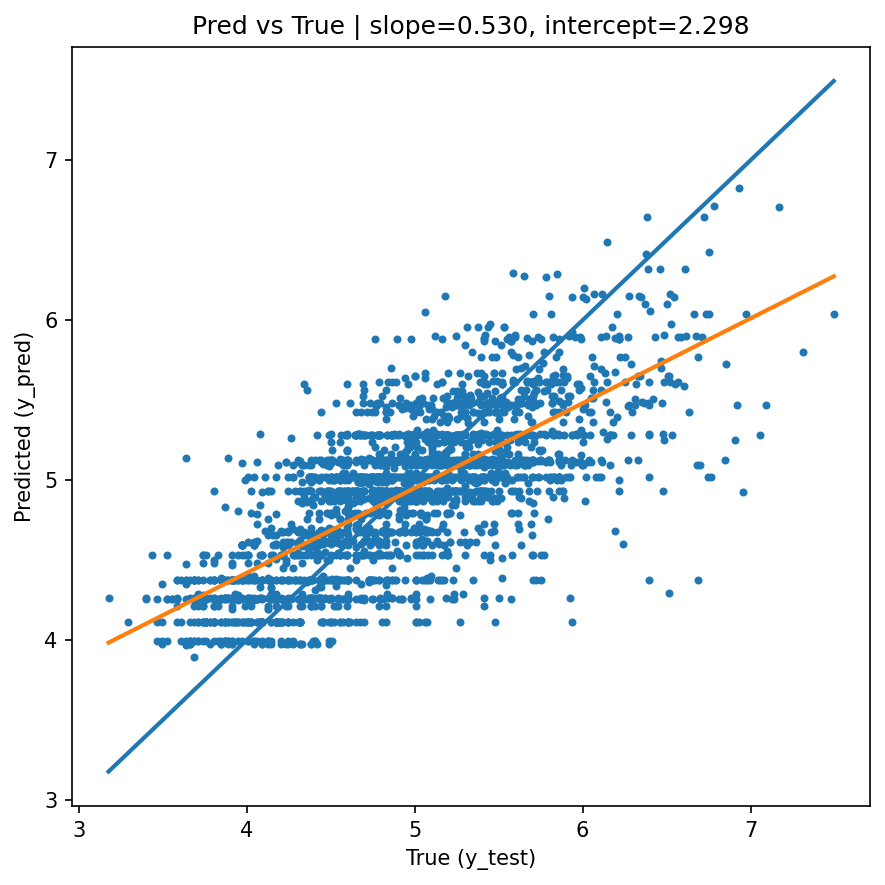

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# y_test, y_pred가 이미 만들어져 있다고 가정
y_true = np.asarray(y_test)
y_pred = np.asarray(y_pred)

plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(y_true, y_pred, s=8)

# 1) 이상적인 선: y = x
mn = min(y_true.min(), y_pred.min())
mx = max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], linewidth=2)

# 2) 추세선: y_pred = a*y_true + b
a, b = np.polyfit(y_true, y_pred, 1)
x_line = np.array([mn, mx])
plt.plot(x_line, a * x_line + b, linewidth=2)

plt.xlabel("True (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.title(f"Pred vs True | slope={a:.3f}, intercept={b:.3f}")
plt.tight_layout()
plt.show()


In [25]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import root_mean_squared_error


# 1. neighbourhood_group_cleansed, room_type, accommodates, minimum_nights


# x_cat = df.drop('price_log', axis = 1)
# y_cat = df['price_log'].astype('float')


# cfeatures = ['neighbourhood_group_cleansed', 'room_type', 'accommodates', 'minimum_nights']
# X = df[features].copy()
# y = df['price_log'].astype(float)

# # X, y 같이 결측 제거 (샘플수 맞추기)
# data = pd.concat([X, y.rename("y")], axis=1).dropna()
# X = data[features]
# y = data["y"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# cat_cols = ['neighbourhood_group_cleansed', 'room_type']  # ✅ 컬럼명으로 지정(실수 방지)

# model = CatBoostClassifier(
#     cat_features=cat_cols,
#     random_state=42,
#     verbose=200
# )

# model.fit(X_train, y_train)
# pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, pred)
# rmse = mean_squared_error(y_test, pred, squared=False)
# print("MAE:", mae)
# print("RMSE:", rmse)


# 1) 피처/타깃 정의
features = ['neighbourhood_group_cleansed', 'room_type', 'accommodates', 'minimum_nights', 'beds_clipped']
cat_features = ['neighbourhood_group_cleansed', 'room_type']  # ✅ 범주형

X = df[features].copy()
y = df['price_log'].astype(float) #log
# y = df['price'].astype(float) #original

# 2) 결측 제거 (X,y 같이)
data = pd.concat([X, y.rename("y")], axis=1).dropna()
X = data[features]
y = data["y"]

# (선택) 범주형 dtype 안정화
for c in cat_features:
    X[c] = X[c].astype('category')

# 3) split (회귀라 stratify 없음)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) 모델
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

# ✅ cat_features는 fit에서 주는 게 가장 안전
cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

# 5) 평가
y_pred = cat_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

y_pred = cat_model.predict(X_test)
print("-" * 30)
print(f'Tuned CatBoost R2 : {r2_score(y_test, y_pred):.4f}')
print(f'Tuned CatBoost RMSE : {root_mean_squared_error(y_test, y_pred):.4f}')

C:\Users\for\AppData\Local\Temp\ipykernel_12716\2791552291.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')
C:\Users\for\AppData\Local\Temp\ipykernel_12716\2791552291.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')


0:	learn: 0.6555426	test: 0.6424976	best: 0.6424976 (0)	total: 21.7ms	remaining: 21.7s
100:	learn: 0.4477817	test: 0.4512229	best: 0.4512229 (100)	total: 1.73s	remaining: 15.4s
200:	learn: 0.4435254	test: 0.4497127	best: 0.4497127 (200)	total: 3.29s	remaining: 13.1s
300:	learn: 0.4406529	test: 0.4486862	best: 0.4486862 (300)	total: 4.96s	remaining: 11.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4486375039
bestIteration = 311

Shrink model to first 312 iterations.
------------------------------
Tuned CatBoost R2 : 0.5340
Tuned CatBoost RMSE : 0.4486


In [26]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import root_mean_squared_error


# 1. neighbourhood_group_cleansed, room_type, accommodates, minimum_nights


# x_cat = df.drop('price_log', axis = 1)
# y_cat = df['price_log'].astype('float')


# cfeatures = ['neighbourhood_group_cleansed', 'room_type', 'accommodates', 'minimum_nights']
# X = df[features].copy()
# y = df['price_log'].astype(float)

# # X, y 같이 결측 제거 (샘플수 맞추기)
# data = pd.concat([X, y.rename("y")], axis=1).dropna()
# X = data[features]
# y = data["y"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# cat_cols = ['neighbourhood_group_cleansed', 'room_type']  # ✅ 컬럼명으로 지정(실수 방지)

# model = CatBoostClassifier(
#     cat_features=cat_cols,
#     random_state=42,
#     verbose=200
# )

# model.fit(X_train, y_train)
# pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, pred)
# rmse = mean_squared_error(y_test, pred, squared=False)
# print("MAE:", mae)
# print("RMSE:", rmse)


# 1) 피처/타깃 정의
features = ['neighbourhood_group_cleansed', 'room_type', 'accommodates', 'minimum_nights', 'beds']
cat_features = ['neighbourhood_group_cleansed', 'room_type']  # ✅ 범주형

X = df[features].copy()
y = df['price_log'].astype(float) #log
# y = df['price'].astype(float) #original

# 2) 결측 제거 (X,y 같이)
data = pd.concat([X, y.rename("y")], axis=1).dropna()
X = data[features]
y = data["y"]

# (선택) 범주형 dtype 안정화
for c in cat_features:
    X[c] = X[c].astype('category')

# 3) split (회귀라 stratify 없음)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) 모델
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

# ✅ cat_features는 fit에서 주는 게 가장 안전
cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

# 5) 평가
y_pred = cat_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

y_pred = cat_model.predict(X_test)
print("-" * 30)
print(f'Tuned CatBoost R2 : {r2_score(y_test, y_pred):.4f}')
print(f'Tuned CatBoost RMSE : {root_mean_squared_error(y_test, y_pred):.4f}')

0:	learn: 0.6555426	test: 0.6424976	best: 0.6424976 (0)	total: 17ms	remaining: 17s


C:\Users\for\AppData\Local\Temp\ipykernel_12716\1208866224.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')
C:\Users\for\AppData\Local\Temp\ipykernel_12716\1208866224.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')


100:	learn: 0.4484363	test: 0.4514786	best: 0.4514786 (100)	total: 1.6s	remaining: 14.2s
200:	learn: 0.4438112	test: 0.4495407	best: 0.4495407 (200)	total: 3.08s	remaining: 12.3s
300:	learn: 0.4409960	test: 0.4486923	best: 0.4486923 (300)	total: 4.64s	remaining: 10.8s
400:	learn: 0.4387610	test: 0.4481848	best: 0.4481827 (399)	total: 6.12s	remaining: 9.14s
500:	learn: 0.4367598	test: 0.4478660	best: 0.4478401 (490)	total: 7.64s	remaining: 7.61s
600:	learn: 0.4352690	test: 0.4477868	best: 0.4477302 (581)	total: 9.09s	remaining: 6.04s
700:	learn: 0.4335639	test: 0.4475012	best: 0.4474656 (692)	total: 10.6s	remaining: 4.54s
800:	learn: 0.4320899	test: 0.4472991	best: 0.4472728 (782)	total: 12.2s	remaining: 3.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4472575585
bestIteration = 807

Shrink model to first 808 iterations.
------------------------------
Tuned CatBoost R2 : 0.5369
Tuned CatBoost RMSE : 0.4473


In [29]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import root_mean_squared_error


# 1) 피처/타깃 정의
features = ['neighbourhood_group_cleansed', 'room_type', 'accommodates', 'minimum_nights', 
    'geo_characteristic', 'price_group', 'bathrooms_clipped', 'bedrooms_clipped', 'beds_clipped',
    'luxury_score', 'service_score', 'longterm_score', 'essential_score', 'amenity_count']
cat_features = ['neighbourhood_group_cleansed', 'room_type', 'geo_characteristic', 'price_group']  # ✅ 범주형

X = df[features].copy()
y = df['price_log'].astype(float) #log
# y = df['price'].astype(float) #original

# 2) 결측 제거 (X,y 같이)
data = pd.concat([X, y.rename("y")], axis=1).dropna()
X = data[features]
y = data["y"]

# (선택) 범주형 dtype 안정화
for c in cat_features:
    X[c] = X[c].astype('category')

# 3) split (회귀라 stratify 없음)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) 모델
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

# ✅ cat_features는 fit에서 주는 게 가장 안전
cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

# 5) 평가
y_pred = cat_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

y_pred = cat_model.predict(X_test)
print("-" * 30)
print(f'Tuned CatBoost R2 : {r2_score(y_test, y_pred):.4f}')
print(f'Tuned CatBoost RMSE : {root_mean_squared_error(y_test, y_pred):.4f}')

C:\Users\for\AppData\Local\Temp\ipykernel_12716\2860402252.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')
C:\Users\for\AppData\Local\Temp\ipykernel_12716\2860402252.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')
C:\Users\for\AppData\Local\Temp\ipykernel_12716\2860402252.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

0:	learn: 0.6535451	test: 0.6405760	best: 0.6405760 (0)	total: 25.9ms	remaining: 25.8s
100:	learn: 0.3798704	test: 0.3916301	best: 0.3916301 (100)	total: 1.91s	remaining: 17s
200:	learn: 0.3673702	test: 0.3846723	best: 0.3846723 (200)	total: 3.43s	remaining: 13.6s
300:	learn: 0.3600252	test: 0.3819270	best: 0.3819270 (300)	total: 5.23s	remaining: 12.1s
400:	learn: 0.3542150	test: 0.3797497	best: 0.3797341 (399)	total: 6.87s	remaining: 10.3s
500:	learn: 0.3493366	test: 0.3782830	best: 0.3782501 (498)	total: 8.63s	remaining: 8.59s
600:	learn: 0.3453173	test: 0.3771247	best: 0.3771215 (599)	total: 10.4s	remaining: 6.92s
700:	learn: 0.3412119	test: 0.3765181	best: 0.3765181 (700)	total: 12.1s	remaining: 5.17s
800:	learn: 0.3375741	test: 0.3758991	best: 0.3758878 (798)	total: 13.8s	remaining: 3.43s
900:	learn: 0.3347709	test: 0.3757258	best: 0.3755951 (878)	total: 15.5s	remaining: 1.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.375595139
bestIteration = 878

Shrink 